# Анализ A/B-теста

## Описание проекта

В целях тестирования новой системы рекомендации был проведен A/B-тест. Необходимо провести оценку результатов A/B-теста.

**Задачи**:
* Оценить корректность проведения A/B-теста
* Проанализировать результаты теста

**Техническое задание**:

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**План работ**:
1. Обзор и предварительная обработка данных
2. Оценка корректности проведения A/B-теста.
3. Исследовательский анализ данных.
4. Оценка результатов A/B-теста.
5. Формулирование выводов и рекомендаций.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats as st
import numpy as np
import math as mth

## Обзор и предварительная обработка данных

**Описание данных**:

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

Импорт данных о маркетинговых событиях за 2020 год:

In [2]:
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv', parse_dates=['start_dt', 'finish_dt'])
new_users = pd.read_csv('/datasets/final_ab_new_users.csv', parse_dates=['first_date'])
events = pd.read_csv('/datasets/final_ab_events.csv', parse_dates=['event_dt'])
abpart = pd.read_csv('/datasets/final_ab_participants.csv')

Обзор markening_events:

In [3]:
marketing_events.info()
marketing_events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Проверим датасет на наличие дубликатов:

In [4]:
print('Количество дубликатов marketing_events:',marketing_events.duplicated().sum())

Количество дубликатов marketing_events: 0


Импорт данных о пользователях, зарегистрировавшиеся с 7 по 21 декабря 2020 года:

In [5]:
new_users.info()
new_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Проверим датасет на наличие дубликатов:

In [6]:
print('Количество дубликатов new_users', new_users.duplicated().sum())

Количество дубликатов new_users 0


Импорт данных о действиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:

In [7]:
events.info()
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Проверим датасет на наличие дубликатов:

In [8]:
print('Количество дубликатов events:', events.duplicated().sum())

Количество дубликатов events: 0


В наборе данных присутствуют пропуски. Проверим гипотезу о том, что заполненные значения имеются только у покупок:

In [9]:
len(events.query('event_name == "purchase" and ~details.isna()'))

62740

Действительно, поле details заполнено только у покупок пользователей.

Импорт таблицы участников теста:

In [10]:
abpart.info()
abpart.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Проверим набор данных на наличие дубликатов:

In [11]:
print('Количество дубликатов abpart:', abpart.duplicated().sum())

Количество дубликатов abpart: 0


**Вывод**: данные подготовлены для последующего анализа.

## Оценка корректности проведения теста

Выделяем нужный тест:

In [12]:
ab_test = abpart.merge(new_users, on='user_id', how='inner').query('ab_test == "recommender_system_test"')

In [13]:
ab_test

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
4,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
6,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
...,...,...,...,...,...,...
8298,053FB26D6D49EDDC,A,recommender_system_test,2020-12-10,N.America,Android
8299,9D263B8EF15CF188,B,recommender_system_test,2020-12-16,N.America,Mac
8300,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-18,APAC,Mac
8301,29C92313A98B1176,B,recommender_system_test,2020-12-07,APAC,Android


Проверяем количество групп и распределение участников в них:

,user_id
group,
A,3824
B,2877


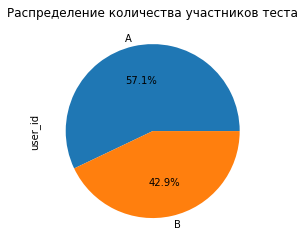

In [14]:
ab_test.groupby('group').user_id.nunique().to_frame().plot(kind='pie', 
                                           x='group', y='user_id', 
                                           autopct='%1.1f%%', legend=False);
plt.title('Распределение количества участников теста');
display(ab_test.groupby('group').user_id.nunique().to_frame())

В контрольной группе больше участников, чем в тестовой, однако "перекос" нельзя назвать критичным. Суммарно в двух тестовых группах 6701 участник, что примерно на 11% превышает требуемое количество.

Проверим соотношение аудитории внутри целевого теста:

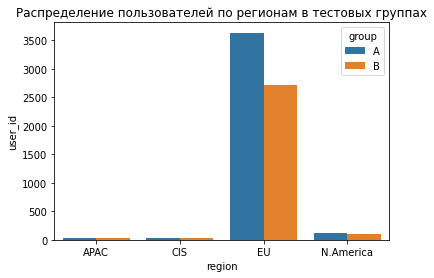

In [15]:
sns.barplot(data=ab_test.groupby(['group', 'region']).user_id.count().to_frame().reset_index(), x='region', y='user_id', hue='group');
plt.title('Распределение пользователей по регионам в тестовых группах');

Нетрудно заметить, что большинство пользователей теста действительно из региона EU, однако в относительно небольшом количестве встречаются пользователи и из других регионов. 

In [16]:
print('Количество новых пользователей из региона EU:', len(new_users[new_users.region == 'EU']))
print('Количество участников теста:', len(abpart[abpart.ab_test == 'recommender_system_test']))
print('Для пользователей целевого теста относительно новых пользователей из EU', len(abpart[abpart.ab_test == 'recommender_system_test']) / len(new_users[new_users.region == 'EU']) )

Количество новых пользователей из региона EU: 46270
Количество участников теста: 6701
Для пользователей целевого теста относительно новых пользователей из EU 0.144823859952453


Здесь можно было бы считать, что требование технического задания практически исполнено в пределах погрешности, однако, стоит обратить внимание на тот факт, что не все участники теста из региона EU, что является нарушением технического задания.

Пользователей из других регионов необходимо исключить из теста (так как мы однозначно не уверены, не имеют ли нововведения каких-то локальных особенностей региона) . Сделаем это позднее.

Проверим нахождение пользователей в двух группах:

In [17]:
ab_test_a = ab_test.query('group == "A"')
ab_test_b = ab_test.query('group == "B"')

In [18]:
print('Количество пользователей, попавших одновременно в две группы:', ab_test_a.user_id.isin(ab_test_b.user_id).sum())

Количество пользователей, попавших одновременно в две группы: 0


Тестовые группы не пересекаются.

Проверим соответствие дат техническому заданию:

In [19]:
ab_test_a_events = ab_test_a.merge(events, on='user_id', how='inner')
ab_test_b_events = ab_test_b.merge(events, on='user_id', how='inner')

In [20]:
print('Дата начала набора пользователей в группе А: ', ab_test_a_events.first_date.min())
print('Дата окончания набора пользователей в группе А: ', ab_test_a_events.first_date.max())
print('Дата последнего зафиксированного события в группе А: ', ab_test_a_events.event_dt.max())
print('------')
print('Дата начала набора пользователей в группе B: ', ab_test_b_events.first_date.min())
print('Дата окончания набора пользователей в группе B: ', ab_test_b_events.first_date.max())
print('Дата последнего зафиксированного события в группе B: ', ab_test_b_events.event_dt.max())

Дата начала набора пользователей в группе А:  2020-12-07 00:00:00
Дата окончания набора пользователей в группе А:  2020-12-21 00:00:00
Дата последнего зафиксированного события в группе А:  2020-12-29 23:38:29
------
Дата начала набора пользователей в группе B:  2020-12-07 00:00:00
Дата окончания набора пользователей в группе B:  2020-12-21 00:00:00
Дата последнего зафиксированного события в группе B:  2020-12-30 12:42:57


Фактически тест завершился раньше установленной в техническом задании даты, что принципиально не противоречит техническому заданию. Вероятно, это связано с новогодними выходными. В целом, проводить A/B-тест в праздничные дни не совсем корректно, так как результаты могут быть сильно искажены. Однако, важным моментом является факт, что часть пользователей не соответствует требованию о 14-дневном периоде. То есть часть пользователей не смогли пройти весь заданный период теста.

Проверим, не участвовали ли пользователи исследуемого теста в конкурирующем тесте.

In [21]:
ab_test_2 = new_users.merge(abpart, on='user_id', how='inner').query('ab_test == "interface_eu_test"')

In [22]:
print('Количество пользователей, участвующих в двух тестах одновременно:', ab_test_2.user_id.isin(ab_test.user_id).sum())

Количество пользователей, участвующих в двух тестах одновременно: 1602


Довольно большое количество пользователей участвует в двух группах одновременно. Проверим, сколько из них находится в контрольных группах (т.к. нахождение в двух контрольных группах не мешает участвовать в двух тестах). Предположим, что во втором тесте группа А также является контрольной.

In [23]:
ab_test_2_a = ab_test_2.query('group == "A"')
ab_test_2_b = ab_test_2.query('group == "B"')

In [24]:
print('Количество участников конкурирующего теста из группы А в группе А целевого теста:', ab_test_2_a.user_id.isin(ab_test_a.user_id).sum())
print('Количество участников конкурирующего теста из группы В в группе А целевого теста:',ab_test_2_b.user_id.isin(ab_test_a.user_id).sum())
print('Количество участников конкурирующего теста из группы А в группе В целевого теста:',ab_test_2_a.user_id.isin(ab_test_b.user_id).sum())
print('Количество участников конкурирующего теста из группы В в группе В целевого теста:',ab_test_2_b.user_id.isin(ab_test_b.user_id).sum())

Количество участников конкурирующего теста из группы А в группе А целевого теста: 482
Количество участников конкурирующего теста из группы В в группе А целевого теста: 439
Количество участников конкурирующего теста из группы А в группе В целевого теста: 337
Количество участников конкурирующего теста из группы В в группе В целевого теста: 344


Из целевого теста необходимо исключить пользователей, которые участвуют в группе В конкурирующего теста, так как такие пользователи могут внести значительные искажения в реальные результаты, тем более, что таких пользователей немало.

Проверим период проведения теста на наличие маркетинговых акций:

In [25]:
marketing_events.sort_values(by='finish_dt')

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


Нетрудно заметить, что во время проведения теста в регионе EU параллельно проводилась маркетинговае акция Christmas&New Year Promo, что также может повлиять на результаты теста.

**Сформируем итоговые наборы данных**

Исключаем пользователей из группы В конкурирующего теста:

In [26]:
ab_test = ab_test[~ab_test.user_id.isin(ab_test_2_b.user_id)]

Оставляем пользователей только из региона EU:

In [27]:
ab_test = ab_test[ab_test.region == 'EU']

Разделяем на два отдельных датасета и исключаем ненужный атрибут:

In [28]:
ab_test_a = ab_test.query('group == "A"').drop(['device'], axis=1)
ab_test_b = ab_test.query('group == "B"').drop(['device'], axis=1)

Присоединяем все события:

In [29]:
ab_test_a_events = ab_test_a.merge(events, on='user_id', how='inner')
ab_test_b_events = ab_test_b.merge(events, on='user_id', how='inner')

Исключаем все события, которые не уклыдываются в 14-дневный период для каждого пользователя:

In [30]:
ab_test_a_events['interval'] = (ab_test_a_events.event_dt - ab_test_a_events.first_date).dt.days
ab_test_b_events['interval'] = (ab_test_b_events.event_dt - ab_test_b_events.first_date).dt.days
ab_test_a_events = ab_test_a_events[ab_test_a_events.interval <= 14].drop(['interval'], axis=1)
ab_test_b_events = ab_test_b_events[ab_test_b_events.interval <= 14].drop(['interval'], axis=1)

**Вывод**:
В целом, условия проведения теста, трудно назвать идеальными и полностью соответствующими техническому заданию. Допущенные ошибки:
1. Участники в группе А и В распределены неравномерно. Присутствует смещение в сторону контрольной группы.
2. Практически все участники теста из региона EU, однако нельзя сказать, что требование о 15% новых пользователей из EU соблюдено, т.к. есть пользователи из других регионов и количество пользователей менее 15%. Пользователи из других регионов исключены из рассмотрения.
3. Ряд пользователей участвует также в конкурирующем тесте, такие пользователи исключены из рассмотрения.
4. В конце периода проведения теста параллельно проводились маркетинговые акции.
5. Тест проводился в предновогодний период, что также может повлиять на реальную картину, так как поведение пользователей в праздники, вероятнее всего, изменяется.
6. Не все пользователи смогли "прожить" двухнедельный период.


## Исследовательский анализ данных

### Исследование количества событий в выборках

Проверим количество событий в двух тестовых группах:

In [31]:
print('Количество событий в группе А:', len(ab_test_a_events))
print('Количество событий в группе B:', len(ab_test_b_events))

Количество событий в группе А: 15851
Количество событий в группе B: 4183


Посмотрим на количество событий по дням в двух группах с динамикой по дням:

In [32]:
ab_test_a_events['event_day'] = ab_test_a_events.event_dt.dt.date
ab_test_b_events['event_day'] = ab_test_b_events.event_dt.dt.date

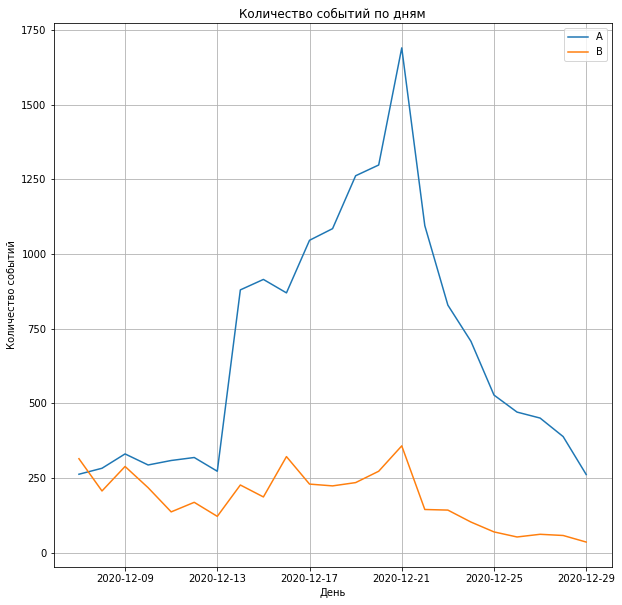

In [33]:
fig,ax = plt.subplots(figsize=(10,10))
ab_test_a_events.groupby('event_day').event_name.count().to_frame().reset_index().plot(x='event_day', y='event_name', label='A', ax=ax);
ab_test_b_events.groupby('event_day').event_name.count().to_frame().reset_index().plot(x='event_day', y='event_name', label='B', ax=ax);
plt.grid(True)
plt.title('Количество событий по дням');
plt.xlabel('День');
plt.ylabel('Количество событий');

Посмотрим на гистограммы количества событий в разрезе групп и в целом:

In [34]:
ab_hist = pd.concat([ab_test_a_events, ab_test_b_events])

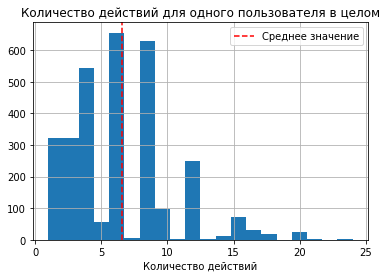

In [35]:
ab_hist.groupby('user_id')['event_name'].count().hist(bins=20);
plt.title('Количество действий для одного пользователя в целом');
plt.xlabel('Количество действий');
plt.axvline(ab_hist.groupby('user_id')['event_name'].count().mean(), color='red', linestyle='--', label='Среднее значение');
plt.legend();

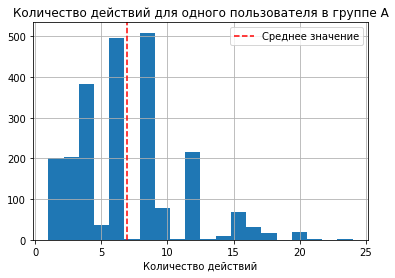

In [36]:
ab_hist[ab_hist.group == 'A'].groupby('user_id')['event_name'].count().hist(bins=20);
plt.title('Количество действий для одного пользователя в группе А');
plt.xlabel('Количество действий');
plt.axvline(ab_hist[ab_hist.group == 'A'].groupby('user_id')['event_name'].count().mean(), color='red', linestyle='--', label='Среднее значение');
plt.legend();

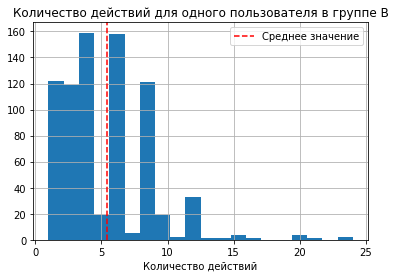

In [37]:
ab_hist[ab_hist.group == 'B'].groupby('user_id')['event_name'].count().hist(bins=20);
plt.title('Количество действий для одного пользователя в группе B');
plt.xlabel('Количество действий');
plt.axvline(ab_hist[ab_hist.group == 'B'].groupby('user_id')['event_name'].count().mean(), color='red', linestyle='--', label='Среднее значение');
plt.legend();

**Вывод**: очевидно, что тестовая группа по каким-то причинам намного менее активна, чем контрольная. Количество событий по дням имеет разную динамику, но похожие тренды. Можно предположить, что более низкая активность вызвана тем, что процесс покупки стал проще. Также стоит заметить, что количество действий в разрезе одного пользователя в тестовой группе в среднем немного меньше.

### Исследование воронки продаж

In [38]:
ab_test_a_conv = ab_test_a_events.groupby('event_name').user_id.nunique().to_frame().reset_index()
ab_test_a_conv['total_users'] = len(ab_test_a)
ab_test_a_conv['conversion'] = ab_test_a_conv.user_id / ab_test_a_conv.total_users
ab_test_a_conv['group'] = 'A'
ab_test_a_conv

,event_name,user_id,total_users,conversion,group
0,login,2279,3195,0.713302,A
1,product_cart,686,3195,0.214710,A
2,product_page,1476,3195,0.461972,A
3,purchase,734,3195,0.229734,A


In [39]:
ab_test_b_conv = ab_test_b_events.groupby('event_name').user_id.nunique().to_frame().reset_index()
ab_test_b_conv['total_users'] = len(ab_test_b)
ab_test_b_conv['conversion'] = ab_test_b_conv.user_id / ab_test_b_conv.total_users
ab_test_b_conv['group'] = 'B'
ab_test_b_conv

,event_name,user_id,total_users,conversion,group
0,login,770,2373,0.324484,B
1,product_cart,214,2373,0.090181,B
2,product_page,429,2373,0.180784,B
3,purchase,219,2373,0.092288,B


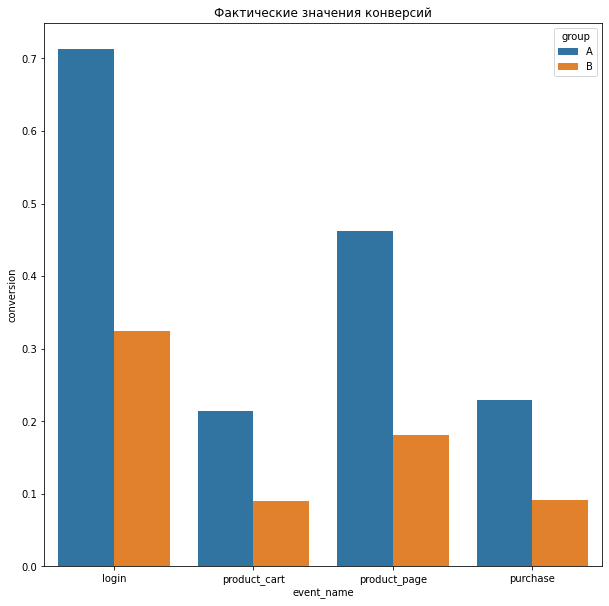

In [40]:
plt.figure(figsize=(10,10))
sns.barplot(data=pd.concat([ab_test_a_conv,ab_test_b_conv]), x='event_name', y='conversion', hue='group');
plt.title('Фактические значения конверсий');

**Вывод**:
1. Очевидно, что по всем событиям конверсия в контрольной группе значительно выше, чем в тестовой.
2. По всей видимости, в магазине реализована какая-то механика покупки в обход корзины (об этом свидетельствует тот факт, что покупок больше, чем посещений корзины).

## Оценка результатов A/B-теста

Необходимо проверить гипотезы о том, за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:

* конверсии в просмотр карточек товаров — событие `product_page`,
* просмотры корзины — `product_cart`,
* покупки — `purchase`.
    
**H0**: Конверсии в просмотр карточек товаров/посмотр корзины/покупки не различаются в зависимости от группы.

**H1**: Конверсии в просмотр карточек товаров/посмотр корзины/покупки различаются в зависимости от группы.

Метод проверки: z-тест

Определим пороговый уровень значимости равным 0.05 (в тестах скорректирован с помощью поправки Бонферрони), так как эксперимент не является высокоточным.

Определим функцию, позволяющую реализовать Z-тест:

In [41]:
def z_test(events, totals, alpha=.05):
    p1 = events[0]/totals[0]
    p2 = events[1]/totals[1]
    p_combined = (events[0] + events[1]) / (totals[0] + totals[1])
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/totals[0] + 1/totals[1]))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

Проведем z-тест для всех метрик:

In [42]:
for x in ab_test_a_conv[ab_test_a_conv.event_name != 'login'].event_name:
    print(f'Гипотеза о равенстве долей {x}')
    events_test = np.array([int(ab_test_a_conv[ab_test_a_conv.event_name == x].user_id), int(ab_test_b_conv[ab_test_b_conv.event_name == x].user_id)])
    totals_test = np.array([int(ab_test_a_conv[ab_test_a_conv.event_name == x].total_users), int(ab_test_b_conv[ab_test_b_conv.event_name == x].total_users)])
    z_test(events_test, totals_test, alpha = 0.05/3)
    print(f'----------')

Гипотеза о равенстве долей product_cart
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
----------
Гипотеза о равенстве долей product_page
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
----------
Гипотеза о равенстве долей purchase
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
----------


**Вывод**: результаты всех тестов показали статистически значимые различия двух групп. Таким образом, можно считать, что нововведение ухудшает все метрики и от него необходимо отказаться.

## Заключение

В процессе работы были выполнены следующий этапы:
1. Проведен обзор и предварительная обработка данных.
2. Произведена оценка корректности проведения теста
3. Проведен исследовательский анализ данных
4. Оценены и интерпретированы результаты A/B-теста.

**Ключевые выводы**:
1. A/B-тест проведен со значительными нарушениями, что могло исказить действительный результат:
    * Участники в группе А и В распределены неравномерно. Присутствует смещение в сторону контрольной группы.
    * Практически все участники теста из региона EU, однако нельзя сказать, что требование о 15% новых пользователей из EU соблюдено, т.к. есть пользователи из других регионов и количество пользователей менее 15%.
    * Ряд пользователей участвует также в конкурирующем тесте, такие пользователи исключены из рассмотрения.
    * В конце периода проведения теста параллельно проводились маркетинговые акции.
    * Тест проводился в предновогодний период, что также может повлиять на реальную картину, так как поведение пользователей в праздники, вероятнее всего, изменяется.
    * Не все пользователи смогли "прожить" двухнедельный период.
2. Результаты теста показали, что новый вариант системы рекомендаций не оправдал себя. Конверсия по всем этапам воронки продаж статистически значимо ниже контрольной группы.

**Рекомендации**:
1. В случае, если условия проведения теста с учетом всех замечаний считаются корректными для компании-заказчика, то от нововведения следует отказаться.
2. Если внутренняя аналитика компании показывает, что такое нововведение может быть полезно, то необходимо провести тест повторно с учетом всех замечаний по условиям проведения теста.
3. Результатам теста, в целом, доверять не следует, так как несколько пунктов технического задания были нарушены (хотя, стоит отметить, что критических нарушений технического задания нет), а также часть временного интервала проведения теста приходится на период проведения маркетинговой акции в соответствующем регионе и предновогодний период, что может вызывать непредсказуемую активность. Также опасения вызывает низкая активность пользователей в тестовой группе, возможно, следует проверить новый функционал на наличие ошибок в работе.
4. При проведении тестов в будущем следует выбирать временной интервал, исключающий праздничные дни, проведение маркетинговых акций и прочие несезонные факторы, которые могут влиять на активность пользователей. Также необходимо более строго придерживаться установленного технического задания.